# Models

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin

from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('./data_prepared.csv')

In [3]:
X = df.drop('Rating', axis=1)
y = df['Rating']

Encode categorical features and normalize numerical features.

In [4]:
encoders = ['CatBoostEncoder', 'GLMMEncoder', 'JamesSteinEncoder', 
            'LeaveOneOutEncoder', 'MEstimateEncoder', 'TargetEncoder', 
            'BinaryEncoder', 'HashingEncoder', 'OrdinalEncoder']

class CatEncoder(TransformerMixin):
    def __init__(self, enc_name='MEstimateEncoder', **kwargs):
        exec('from category_encoders import %s' % enc_name)
        exec('self.encoder = %s(**kwargs)' % enc_name)
    
    def fit(self, X, y=None):
        return self.encoder.fit(X, y)
    
    def transform(self, X, y=None):
        return self.encoder.transform(X, y)
    
    def set_params(self, **params):
        print(params)
        return self.encoder.set_params(**params)

In [5]:
num_columns = ['Review Date', 'Cocoa Percent']
cat_columns = df.select_dtypes(exclude='number').columns.tolist()

# Categorical encoding
#cat_enc = CatEncoder()
#cat_enc.fit(X_train, y_train)

#X_train_trans = cat_enc.transform(X_train, y_train)
#X_test_trans = cat_enc.transform(X_test, y_test)

# Normalize numerical columns
num_enc = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns)],
    remainder='passthrough')
#num_enc.fit(X_train_trans)

In [6]:
# Utility function for evaluation
def eval_mod(model):
    y_pred = model.predict(X_test)
    
    print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('MAE:', mean_absolute_error(y_test, y_pred))
    print('R^2:', r2_score(y_test, y_pred))

# Evaluate encoders
def eval_encoders(model):
    scores = []
    for enc in encoders:
        pipeline = Pipeline([('cat_enc', CatEncoder(enc)), 
                             ('scaler', num_enc), 
                             ('mod', model)])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(rmse)
    
    return pd.Series(scores, index=encoders).sort_values()

## PCA

In [7]:
pca = Pipeline([('cat_enc',CatEncoder('CatBoostEncoder')), 
                   ('scaler', num_enc), 
                   ('pca', PCA(n_components=3))])
pca.fit(X, y)

X_pca = pd.DataFrame(pca.transform(X))

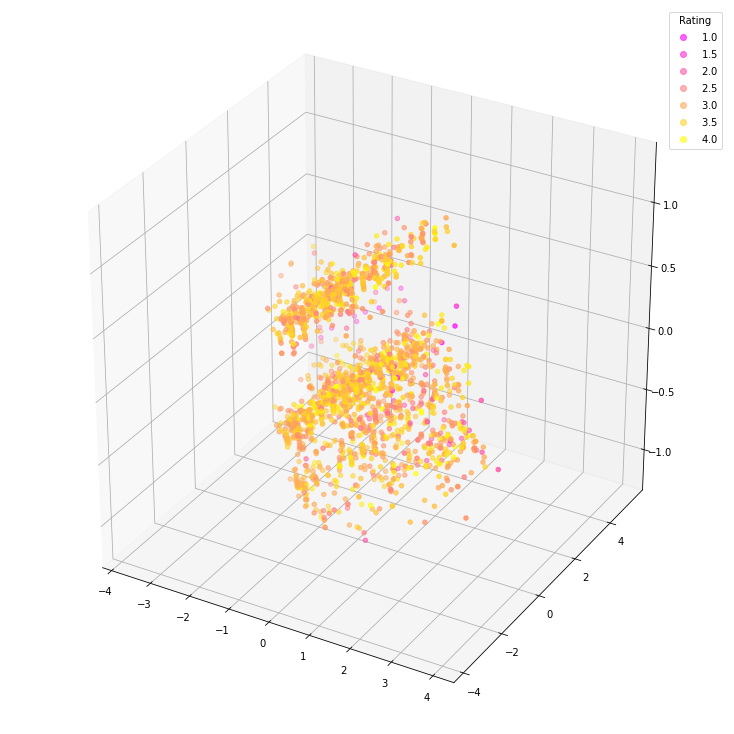

In [14]:
fig = plt.figure(figsize=(10, 10))

ax = Axes3D(fig)
scatter = ax.scatter(X_pca[0], X_pca[1], X_pca[2], c=y, cmap='spring')
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6, num=6)
legend = ax.legend(handles, labels, loc="upper right", title="Rating")
plt.show()

In [9]:
pca2d = Pipeline([('cat_enc',CatEncoder('CatBoostEncoder')), 
                   ('scaler', num_enc), 
                   ('pca', PCA(n_components=2))])
pca2d.fit(X, y)

X_pca2d = pd.DataFrame(pca2d.transform(X))

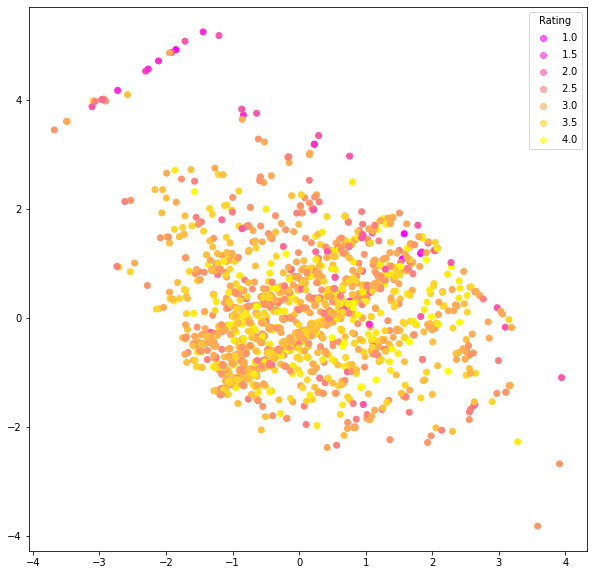

In [10]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(X_pca2d[0], X_pca2d[1], c=y, cmap='spring')
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6, num=6)
legend = ax.legend(handles, labels, loc="upper right", title="Rating")
plt.show()

In [11]:
pd.DataFrame(np.abs(pca2d['pca'].components_).T, index=X.columns).sort_values(0).head(20)

,0,1
Sub-region_company,0.000173,0.000366
musty,0.000537,0.004187
Continent_company,0.000613,0.000872
smokey,0.001686,0.000191
Country of Bean Origin,0.002367,0.000726
astringent,0.002675,0.000719
off,0.003254,0.012478
bland,0.003277,0.002012
Company,0.003891,0.018705
grass,0.004022,0.001613


In [12]:
pd.DataFrame(np.abs(pca2d['pca'].components_).T, index=X.columns).sort_values(1).head(20)

,0,1
smokey,0.001686,0.000191
Sub-region_company,0.000173,0.000366
astringent,0.002675,0.000719
Country of Bean Origin,0.002367,0.000726
Continent_company,0.000613,0.000872
Sa,0.006331,0.001372
grass,0.004022,0.001613
earthy,0.019017,0.001847
bland,0.003277,0.002012
floral,0.014329,0.002493


In [13]:
help(pca2d['pca'])

Help on PCA in module sklearn.decomposition._pca object:

class PCA(sklearn.decomposition._base._BasePCA)
 |  PCA(n_components=None, *, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
 |  
 |  Principal component analysis (PCA).
 |  
 |  Linear dimensionality reduction using Singular Value Decomposition of the
 |  data to project it to a lower dimensional space. The input data is centered
 |  but not scaled for each feature before applying the SVD.
 |  
 |  It uses the LAPACK implementation of the full SVD or a randomized truncated
 |  SVD by the method of Halko et al. 2009, depending on the shape of the input
 |  data and the number of components to extract.
 |  
 |  It can also use the scipy.sparse.linalg ARPACK implementation of the
 |  truncated SVD.
 |  
 |  Notice that this class does not support sparse input. See
 |  :class:`TruncatedSVD` for an alternative with sparse data.
 |  
 |  Read more in the :ref:`User Guide <PCA>`.
 |  
 |